In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from matplotlib.image import imread
import time
from scipy.ndimage.filters import convolve,gaussian_filter
from sklearn.model_selection import train_test_split
import numpy as np
import random
import winsound

In [2]:
mat = scipy.io.loadmat('mnist-original.mat') # lecture du fichier

In [3]:
data = np.transpose(mat['data'])
label = np.transpose(mat['label'])

In [4]:
X = [] # on créé une nouvelle liste qui va contenir nos matrices 
for i in range(len(data)):
    X.append(gaussian_filter((255-data[i]).reshape(28,28),sigma=1)) # pour avoir des matrices lisses

In [71]:
def index_chiffre(n, y):  # elle nous renvoie un tableau contenant les indices représentants le chiffre n
    index = []           # j'ai rajouté le y dans les arguments car je me servirai de cette fonction dans la suite
    for i in range(len(y)):
        if y[i]==n:
            index.append(i)
    return index

In [44]:
def deriv_x(X): # dérivée par rapport à x en appliquant un filtre de Sobel
    P = X.reshape(28,28)
    temp = np.gradient(P)[0]
    return temp


def deriv_y(X): # derivée par rapport à y
    P = X.reshape(28,28)
    temp = np.gradient(P)[1]
    return temp

In [55]:
# pour la rotation
def deriv_rot(derX, derY):
    p = np.zeros((28,28))
    for i in range(28):
        for j in range(28):
            p[i][j] = j*derX[i][j]-i*derY[i][j]
    return p

In [56]:
# pour rendre le dessin plus gras
def thickening(derX, derY):
    p = np.zeros((28,28))
    for i in range(28):
        for j in range(28):
            p[i][j] = derX[i][j]**2 + derY[i][j]**2
    return p

In [57]:
# scaling
def scaling(derX, derY):
    p = np.zeros((28,28))
    for i in range(28):
        for j in range(28):
            p[i][j] = i*derX[i][j]+j*derY[i][j]
    return p

In [58]:
# transformation parallèle hyperbolique
def par_hyper(derX, derY):
    p = np.zeros((28,28))
    for i in range(28):
        for j in range(28):
            p[i][j] = i*derX[i][j]-j*derY[i][j]
    return p

In [59]:
# transformation diagonale hyperbolique
def diag_hyper(derX, derY):
    p = np.zeros((28,28))
    for i in range(28):
        for j in range(28):
            p[i][j] = j*derX[i][j]+i*derY[i][j]
    return p

In [60]:
def tangent_matrix(derX, derY):
    p = np.zeros((784,7))
    p[:,0] = derX.reshape(784,)
    p[:,1] = derY.reshape(784,)
    p[:,2] = deriv_rot(derX, derY).reshape(784,)
    p[:,3] = thickening(derX, derY).reshape(784,)
    p[:,4] = scaling(derX, derY).reshape(784,)
    p[:,5] = par_hyper(derX, derY).reshape(784,)
    p[:,6] = diag_hyper(derX, derY).reshape(784,)
    return p

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, label, test_size=0.2)

In [62]:
# on va maintenant calculer la matrice tangente de chaque élément de X_train
start = time.time()
mat_tangent = np.zeros(len(X_train), dtype=object)
for i in range(len(X_train)):
    derX = deriv_x(X_train[i])
    derY = deriv_y(X_train[i])
    mat_tangent[i] = tangent_matrix(derX, derY)
print(time.time()-start)

218.61397314071655


In [63]:
temp = random.sample(range(14000),100)

In [211]:
# on va faire un test sur 100 éléments en calculant la distance entre les matrices tangentes seulement
start = time.time()
p = 0
for i in temp:
    matTest = X_test[i]
    derTX = deriv_x(matTest)
    derTY = deriv_y(matTest)
    tang_test = tangent_matrix(derTX, derTY)
    dist = [0 for k in range(56000)]
    for j in range(56000):
        dist[j]=np.linalg.norm(tang_test - mat_tangent[j], ord=2)
    pred = np.argmin(np.array(dist)) # l'indice de la matrice de X_train la plus proche
    if y_test[i] == y_train[pred]:
        p+=1
print(time.time()-start)
print(p/100)

418.1969618797302
0.81


##### Dans les prochaines lignes on va implémenter une méthode pour calculer la transformation de Householder (pour obtenir Q1 et Q2)

In [64]:
def householder(A): # comme on veut aller jusqu'à Q2 on va le faire manuellement
    n = A.shape[0] # nombre de lignes de A
    I = np.eye(n)
    x = A[:,0].reshape(n,1)
    a = -np.sign(x[0])*np.linalg.norm(x, ord=2)
    u = x + a*I[:,0].reshape(n,1)
    v = u/np.linalg.norm(u, ord=2)
    Q1 = I - 2*(v@np.transpose(v)) 
    temp = Q1@A
    
    A_prime = temp[1:,1:] # on refait les mêmes étapes pour A_prime qui est une matrice dont le nombre de lignes = n-1
    I = np.eye(n-1)
    x = A_prime[:,0].reshape(n-1,1)
    a = -np.sign(x[0])*np.linalg.norm(x, ord=2)
    u = x + a*I[:,0].reshape(n-1,1)
    v = u/np.linalg.norm(u, ord=2)
    Q2_prime = I - 2*(v@np.transpose(v))
    Q2 = np.zeros((n,n))
    Q2[0][0] = 1
    Q2[1:,1:] = Q2_prime
    
    return (Q1, Q2)

In [65]:
def dist_tang_all(M): # elle calcule la distance tangente entre M et toutes les matrices d'entraînement
    derxM = deriv_x(M)
    deryM = deriv_y(M)
    Tm = tangent_matrix(derxM, deryM)
    dist = np.zeros((len(mat_tangent)))
    for i in range(len(mat_tangent)):
        A = np.concatenate((-Tm, mat_tangent[i]),axis=1) # mat_tangent[i] représente la matrice tangente de X_train[i]
        b = (M - X_train[i]).reshape(784,1) # car ils sont dans leurs formes matricielles et on veut que b soit un vecteur
        Q2 = householder(A)[1]
        dist[i] = np.linalg.norm(np.transpose(Q2)@b, ord=2)**2
    return dist

##### La prochaine ligne ne doit pas être executée, elle prend BEAUCOUP de temps

In [ ]:
# on va faire un test sur 100 éléments avec la distance tangente
temp = random.sample(range(14000),100)
start = time.time()
p = 0
for i in temp:
    matTest = X_test[i]
    pred = np.argmin(dist_tang_all(matTest)) # l'indice de la matrice de X_train la plus proche
    if y_test[i] == y_train[pred]:
        p+=1
print(time.time()-start)
print(p/100)

In [66]:
# on va maintenant calculer la matrice tangente de chaque élément de X_test
start = time.time()
mat_tangent_test = np.zeros(len(X_test), dtype=object)
for i in range(len(X_test)):
    derX = deriv_x(X_test[i])
    derY = deriv_y(X_test[i])
    mat_tangent_test[i] = tangent_matrix(derX, derY)
print(time.time()-start)

56.87481737136841


##### Comme comparé chaque X_test à tous les X_train prend du temps, on va utilisé une décomposition SVD pour représenter les X_train

In [31]:
mat_svd = np.load('mat_svd.npy', allow_pickle=True)

In [32]:
# dans la méthode SVD on avait vu que le rang qui a une précision moyenne optimale est le rang 15
mat_svd_tronc = np.zeros(10, dtype=object)
for i in range(10):
    U = mat_svd[0][i].reshape(784,784)
    S = mat_svd[1][i].reshape(28,28)
    V = mat_svd[2][i].reshape(784,int(mat_svd[2][i].shape[0]/784))
    temp = U[:,:15]@S[:15,:15]@V[:15,:]
    mat_svd_tronc[i] = normalize(temp[:,10].reshape(28,28))

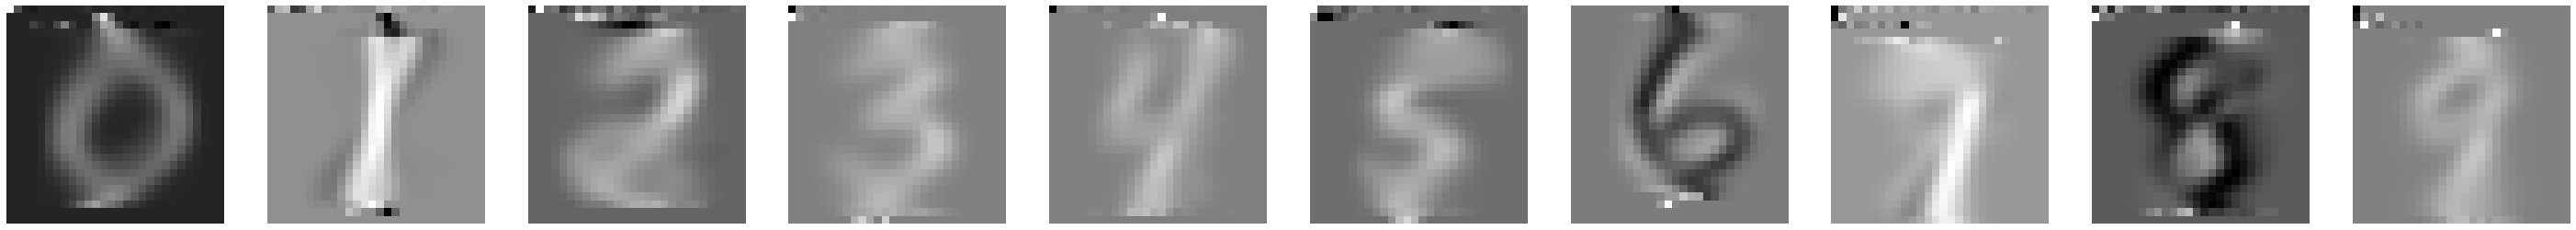

In [33]:
fig, ax = plt.subplots(1,10,figsize=(50,50))
for i in range(10):
    ax[i].imshow(mat_svd_tronc[i].reshape(28,28),cmap='gray')
    ax[i].axis('off')

In [34]:
# on va calculer les matrices tangentes
start = time.time()
mat_tang_svd = np.zeros(10,dtype=object)
for i in range(10):
    derx = deriv_x(mat_svd_tronc[i])
    dery = deriv_y(mat_svd_tronc[i])
    mat_tang_svd[i] = tangent_matrix(derx, dery)
print(time.time()-start) 

0.04493069648742676


In [35]:
# comme on peut le voir on a drastiquement diminué le temps de calcul des matrices tangentes

In [36]:
def dist_tang_svd(M): # la distance tangente entre une matrice X_test et les 10 matrices tangentes qu'on a créé dernièrement
    derxM = deriv_x(M)
    deryM = deriv_y(M)
    Tm = tangent_matrix(derxM, deryM)
    dist = np.zeros(10)
    for i in range(10):
        A = np.concatenate((-Tm, mat_tang_svd[i]),axis=1)
        b = (M - mat_svd_tronc[i]).reshape(784,1)
        Q2 = householder(A)[1]
        dist[i] = np.linalg.norm(np.transpose(Q2)@b,ord=2)
    return dist

In [37]:
# On va tester sur 100 éléments de X_test
temp = random.sample(range(14000),100)
start = time.time()
p = 0
for i in temp:
    matTest = X_test[i]
    pred = np.argmin(dist_tang_svd(matTest)) # l'indice de la matrice de X_train la plus proche
    if y_test[i] == y_train[pred]:
        p+=1
print(time.time()-start)
print(p/100)
    

16.2405903339386
0.15


In [69]:
def image_moyenne(n, X, y): # cette fonction renvoie la matrice moyenne (centroïde) pour le chiffre n
    index = index_chiffre(n, y) # de même je rajoute l'argument X et y car je m'en servirai dans la suite
    sum_matrice = np.zeros((28,28)) # la matrice qui sera utilisée dans la somme
    for i in index:
        sum_matrice += X[i] # on somme toutes les matrices représentants le chiffre n
    return sum_matrice/len(index)

In [72]:
# en utilisant les centroïdes classiques 
centroide_train = []
for i in range(10): # on calcul le centroïde pour chaque chiffre i entre 0 et 9 avec X_train et y_train
    centroide_train.append(image_moyenne(i, X_train, y_train)) 

In [73]:
# calcul des matrices tangentes de chacun des chiffres
start = time.time()
mat_tang_centr = np.zeros(10, dtype=object)
for i in range(10):
    derx = deriv_x(centroide_train[i])
    dery = deriv_y(centroide_train[i])
    mat_tang_centr[i] = tangent_matrix(derx, dery)
print(time.time()-start) 

0.055359840393066406


In [74]:
def dist_tang_centr(M): # la distance tangente entre une matrice X_test et les 10 matrices tangentes qu'on a créé dernièrement
    derxM = deriv_x(M)
    deryM = deriv_y(M)
    Tm = tangent_matrix(derxM, deryM)
    dist = np.zeros(10)
    for i in range(10):
        A = np.concatenate((-Tm, mat_tang_centr[i]),axis=1)
        b = (M - centroide_train[i]).reshape(784,1)
        Q2 = householder(A)[1]
        dist[i] = np.linalg.norm(np.transpose(Q2)@b,ord=2)
    return dist

In [76]:
# On va tester sur 100 éléments de X_test
temp = random.sample(range(14000),100)
start = time.time()
p = 0
for i in temp:
    matTest = X_test[i]
    pred = np.argmin(dist_tang_centr(matTest)) # l'indice de la matrice de X_train la plus proche
    if y_test[i] == y_train[pred]:
        p+=1
print(time.time()-start)
print(p/100)
    

18.77232336997986
0.02


In [ ]:
# j'ai essayé avec des données que j'ai moi même créé

In [77]:
temp = [imread(f'/Users/Nazim/Desktop/Etude/Sorbonne/S6/Projet/chiffres/{i}.png') for i in range(10)]

In [78]:
temp = [temp[i][:,:,0] for i in range(10)]

In [79]:
# calcul des matrices tangentes de chacun des chiffres
start = time.time()
mat_tang_centr = np.zeros(10, dtype=object)
for i in range(10):
    derx = deriv_x(temp[i])
    dery = deriv_y(temp[i])
    mat_tang_centr[i] = tangent_matrix(derx, dery)
print(time.time()-start) 

0.17656159400939941


In [80]:
def dist_tang_centr_dess(M): # la distance tangente entre une matrice X_test et les 10 matrices tangentes qu'on a créé dernièrement
    derxM = deriv_x(M)
    deryM = deriv_y(M)
    Tm = tangent_matrix(derxM, deryM)
    dist = np.zeros(10)
    for i in range(10):
        A = np.concatenate((-Tm, mat_tang_centr[i]),axis=1)
        b = (M - temp[i]).reshape(784,1)
        Q2 = householder(A)[1]
        dist[i] = np.linalg.norm(np.transpose(Q2)@b,ord=2)**2
    return dist

In [81]:
# On va tester sur 100 éléments de X_test
temp = random.sample(range(14000),100)
start = time.time()
p = 0
for i in temp:
    matTest = X_test[i]
    pred = np.argmin(dist_tang_centr_dess(matTest)) # l'indice de la matrice de X_train la plus proche
    if y_test[i] == y_train[pred]:
        p+=1
print(time.time()-start)
print(p/100)
    

21.196595907211304
0.07
